In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib  import cm

from rw import scan_handler
from process import utils as ut

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

%load_ext autoreload
%autoreload 2

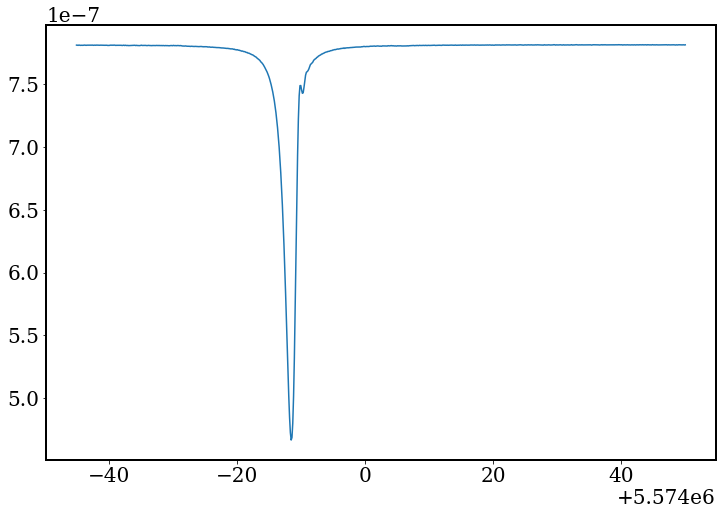

In [2]:
file_path = "/home/cmsdaq/Analysis/Data/RUN_5/processed_data/BAW_5_8.scan"    # path to the .scan file
reader = scan_handler.ScanReader(file_path) 

power = reader.get_parameters('input_power')
f0s = reader.get_parameters('f0')
Qs = reader.get_parameters('Q')
asim = reader.get_parameters('asim')

ii = np.argsort(Qs)

reso = reader.get_resonance(loc=ii[-1])
skip = 40
power = reso['power']
power = (10**(power/10))/1000  #W
freq = reso['freq']

power=power[skip:]
freq = freq[skip:]
plt.plot(freq,power)

In [3]:
import iminuit
from iminuit import cost,Minuit

In [4]:
def set_parameter(minuit_obj=None,name=None,p0=None,pmin=None,pmax=None,step=None,fixed=False):
    m1.values[name] = p0
    m1.limits[name]=(pmin,pmax)
    if step is not None:
        m1.errors[name]=step
    m1.fixed[name]=fixed
    return 


def fitfunc2(x,Pa,P0,f0,Lb,Rl):
    r_P = P0/Pa
    w0 = f0*np.pi*2
    Rb = (-Rl*r_P-Rl*r_P**0.5)/(r_P-1) 
    #Rb = (Rl*r_P**0.5 -Rl*r_P)/(r_P-1)
    Cb = 1./(Lb*w0**2)
    
    Y = x*Lb-1./(x*Cb)
    #numerator = Pa*((Rb*(Rb+Rl)+Y**2)**2 + (Y*Rb)**2)
    #denominator = ( (Rb+Rl)**2+Y**2)**2
    numerator = Pa*(Rb**2+Y**2)
    denominator = (Rb+Rl)**2+Y**2
    return numerator/denominator

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.279e+04 (χ²/ndof = 30.2) │              Nfcn = 141              │
│ EDM = 0.000107 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Pa   │ 781.66e-9 │  0.04e-9  │            │            │7.73407e-07│1.56244e-06│       │
│ 1 │ P0   │ 457.1e-9  │  0.4e-9   │            │            │2.33364e-07│9.33454e-07│       │
│ 2 │ f0   │5.5739883562e6│0.0000000012e6│            │            │5.57396e+06│5.57405e+06│       │
│ 3 │ Lb   │   11.40   │   0.28    │            │            │    1    │   40    │       │
│ 4 │ Rl   │   29.6    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │              Pa              P0              f0              Lb              Rl │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ Pa │        1.47e-21         1.2e-21  -2.0374282e-15 -35.1608586e-15 356.0011694e-15 │
│ P0 │         1.2e-21        1.77e-19   -67.03617e-15 -1.03746850e-12 -5.25304950e-12 │
│ f0 │  -2.0374282e-15   -67.03617e-15        1.45e-06         24.7e-6         58.3e-6 │
│ Lb │ -35.1608586e-15 -1.03746850e-12         24.7e-6          0.0815            0.21 │
│ Rl │ 356.0011694e-15 -5.25304950e-12         58.3e-6            0.21           0.549 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

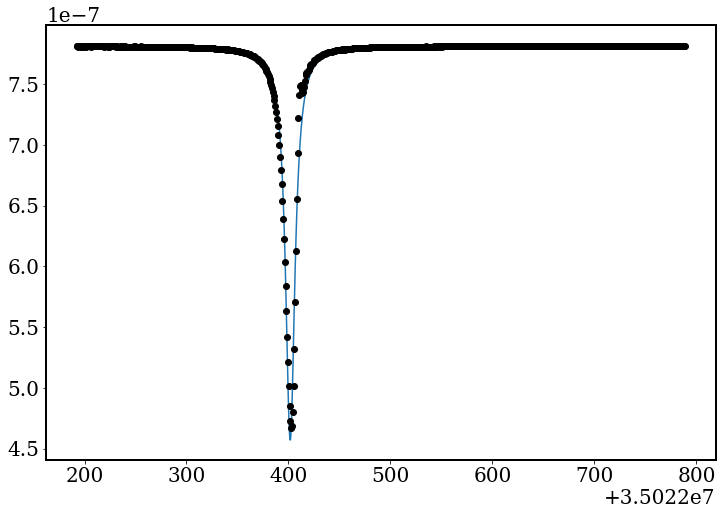

In [5]:
c = cost.LeastSquares(freq*np.pi*2, power, np.ones(len(power))*1e-9, fitfunc2,verbose=0)

m1 = Minuit(c,Pa=0,P0=0,Lb=0,f0=0,Rl=0)

Lb_guess = 10
P0_guess = power[np.argmin(power)]
f0_guess = freq[np.argmin(power)]

set_parameter(m1,'Pa',p0=power[0],pmin=power[0]*0.99,pmax=power[0]*2)
set_parameter(m1,'P0',p0=P0_guess,pmin=P0_guess*0.5,pmax=P0_guess*2)
set_parameter(m1,'Lb',p0=Lb_guess,pmin=1,pmax=40)
set_parameter(m1,'f0',p0=f0_guess,pmin=np.min(freq),pmax=np.max(freq))
set_parameter(m1,'Rl',p0=50,fixed=False)

m1.migrad()

In [6]:
r_P = m1.values['P0']/m1.values['Pa']
w0 = m1.values['f0']*np.pi*2
Rl = m1.values['Rl']
Lb = m1.values['Lb']

Rb = (-Rl*r_P-Rl*r_P**0.5)/(r_P-1) 
Cb = 1./(Lb*w0**2)
print('R = ', Rb, ' [Ohm]')
print('C = ', Cb*1e12, ' [pF]')
print('L = ', Lb, ' [H]')


Q = (1./Rb)  *  ((Lb/(Cb))**0.5)
print("Q = ", "{:e}".format(Q))

R =  96.13704733712319  [Ohm]
C =  7.150327514988359e-05  [pF]
L =  11.402030915287177  [H]
Q =  4.153721e+06
